In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import numpy as np

In [2]:
# load data
data = pd.read_csv("./data/ETH-USD-1d.csv")

# data preprocessing

data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=10)
data['EMAM'] = ta.ema(data['Close'], length=30)
# data['EMAS'] = ta.ema(data['Close'], length=50)
data.ta.bbands(close='Close', length=10, std=2, append=True)
pd.set_option("display.max_columns", None)

data['Target'] = data['Adj Close'] - data['Open']
data['Target'] = data['Target'].shift(-1)
data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Date', 'Volume'], axis=1, inplace=True)
# data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
dataset = data.iloc[:, 0:len(data.columns)]

In [3]:
# data scaling 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
dataset = sc.fit_transform(dataset)

dataset = pd.DataFrame(dataset)

In [4]:
dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.032428,0.032428,0.026651,0.041079,0.031749,0.700832,0.028714,0.024547,0.137399,0.031235,0.023429,0.057933,0.730524,0.544211,0.034821
1,0.000649,0.034821,0.034821,0.029442,0.042798,0.032160,0.755442,0.030084,0.025642,0.140202,0.032746,0.024086,0.050853,0.833135,0.536893,0.033717
2,0.001297,0.033717,0.033717,0.028688,0.044465,0.034871,0.688636,0.030951,0.026528,0.141162,0.033578,0.024770,0.051310,0.709417,0.542670,0.035295
3,0.001946,0.035295,0.035295,0.029180,0.044223,0.033441,0.724936,0.032023,0.027553,0.142427,0.034625,0.025600,0.051466,0.754635,0.566144,0.049261
4,0.002594,0.049261,0.049261,0.041724,0.046073,0.035219,0.894502,0.036122,0.030241,0.135809,0.037327,0.033215,0.121168,0.964746,0.506753,0.031941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,0.997406,0.225742,0.225742,0.206265,0.243920,0.228663,0.680780,0.228150,0.316563,0.278746,0.211939,0.209291,0.253113,0.766247,0.515038,0.213199
1539,0.998054,0.213199,0.213199,0.202354,0.238093,0.226603,0.589116,0.234393,0.320899,0.287403,0.220018,0.216305,0.250293,0.663730,0.497890,0.191648
1540,0.998703,0.191648,0.191648,0.184851,0.212920,0.213902,0.459096,0.234531,0.322286,0.298711,0.225037,0.217378,0.234634,0.534274,0.576274,0.210851
1541,0.999351,0.210851,0.210851,0.189965,0.212485,0.192280,0.538052,0.239072,0.325962,0.318393,0.233501,0.218850,0.208044,0.609717,0.532219,0.207104


In [5]:
# feature engineering
backcandles = 10
X = []
for j in range(len(dataset.columns)):
    X.append([])
    for i in range(backcandles, len(dataset)):
        X[j].append(dataset.iloc[i - backcandles:i, j].values)

X = np.moveaxis(X, [0], [2])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(dataset.iloc[backcandles:, -1].values, dtype=torch.float32).reshape(-1, 1)

In [6]:
# split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# parameters
input_size = X.shape[2]
hidden_size = 150
num_layers = 1
num_epochs = 70
batch_size = 15
learning_rate = 0.0005

In [9]:
model = LSTMModel(input_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [10]:
# train
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/70], Loss: 0.0043
Epoch [20/70], Loss: 0.0023
Epoch [30/70], Loss: 0.0015
Epoch [40/70], Loss: 0.0013
Epoch [50/70], Loss: 0.0012
Epoch [60/70], Loss: 0.0010
Epoch [70/70], Loss: 0.0009


In [11]:
# eval
model.eval()
with torch.no_grad():
    y_pred = model(X_test)


In [12]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.032428,0.032428,0.026651,0.041079,0.031749,0.700832,0.028714,0.024547,0.137399,0.031235,0.023429,0.057933,0.730524,0.544211,0.034821
1,0.000649,0.034821,0.034821,0.029442,0.042798,0.032160,0.755442,0.030084,0.025642,0.140202,0.032746,0.024086,0.050853,0.833135,0.536893,0.033717
2,0.001297,0.033717,0.033717,0.028688,0.044465,0.034871,0.688636,0.030951,0.026528,0.141162,0.033578,0.024770,0.051310,0.709417,0.542670,0.035295
3,0.001946,0.035295,0.035295,0.029180,0.044223,0.033441,0.724936,0.032023,0.027553,0.142427,0.034625,0.025600,0.051466,0.754635,0.566144,0.049261
4,0.002594,0.049261,0.049261,0.041724,0.046073,0.035219,0.894502,0.036122,0.030241,0.135809,0.037327,0.033215,0.121168,0.964746,0.506753,0.031941


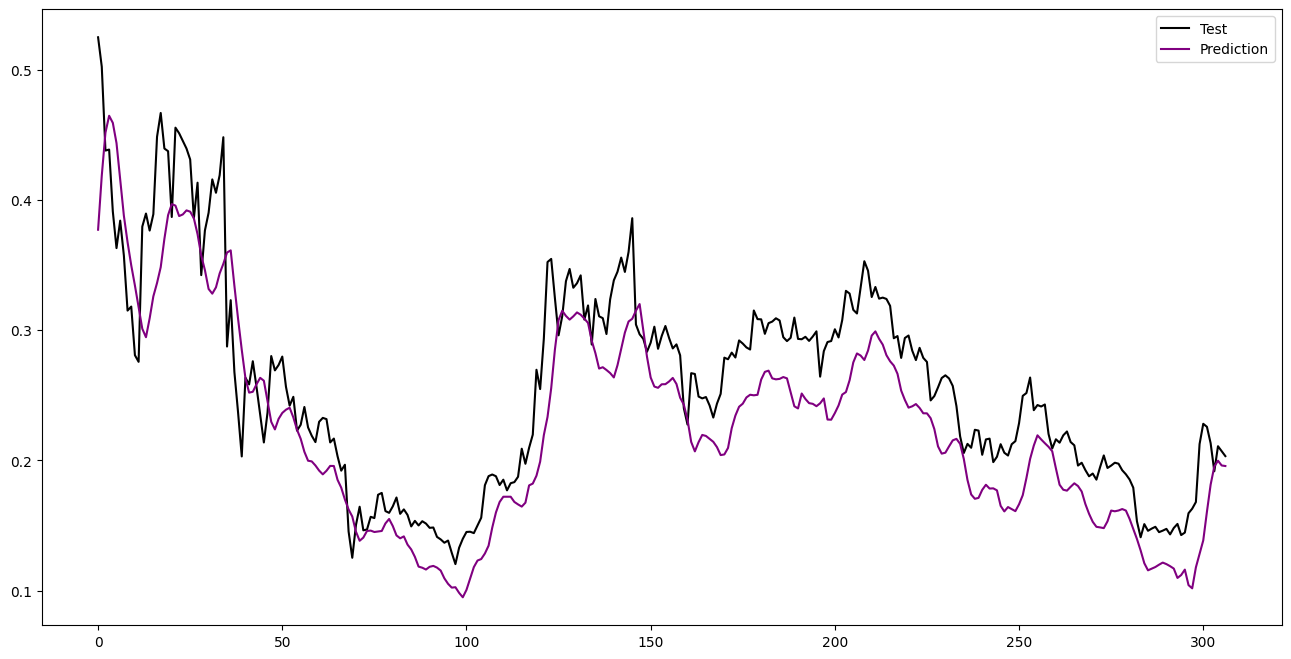

In [13]:
# plot
plt.figure(figsize=(16, 8))
plt.plot(y_test.numpy(), color='black', label='Test')
plt.plot(y_pred.numpy(), color='purple', label='Prediction')
plt.legend()
plt.show()

In [14]:
torch.save(model, 'lstm.pth')